In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

DATASET = "dataset/ai_assistant_usage_student_life.csv"

def load_ai_usage_data():
    if not Path(DATASET).is_file():
        raise TypeError
    return pd.read_csv(Path("dataset/ai_assistant_usage_student_life.csv"))
data = load_ai_usage_data()

In [3]:
## Modifying SessionDate to days since oldest entry
data['SessionDate'] = pd.to_datetime(data['SessionDate'])

oldest_date = pd.to_datetime(datetime.datetime.now())
for date in data['SessionDate']:
    if date >= oldest_date:
        continue
    oldest_date = date
data['DaysSinceFirstSession'] = (data['SessionDate'] - oldest_date).dt.days



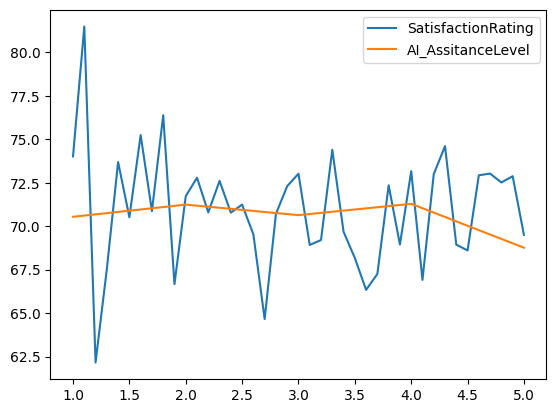

In [4]:
## percentage of students returning to AI depending 
## on their SatisfactionRating and on day of session - not sufficient
used_again_sr = (
    data.groupby('SatisfactionRating')['UsedAgain']
      .mean() * 100
)
used_again_ai_assist = (
    data.groupby('AI_AssistanceLevel')['UsedAgain']
      .mean() * 100
)

plt.plot(used_again_sr, label='SatisfactionRating')
plt.plot(used_again_ai_assist, label='AI_AssitanceLevel')
plt.legend()

Plot indicates there is little correlation between SatisfactionRating or AI_AssistanceLevel and % of Trues in UsedAgain label.

In [5]:
finalOutcome_percent_true = (
    data.groupby("FinalOutcome")["UsedAgain"]
        .mean() * 100
)
taskType_percent_true = (
    data.groupby("TaskType")["UsedAgain"]
        .mean() * 100
)
discipline_percent_true = (
    data.groupby("Discipline")["UsedAgain"]
        .mean() * 100
)
studentLevel_percent_true = (
    data.groupby("StudentLevel")["UsedAgain"]
        .mean() * 100
)
print(finalOutcome_percent_true)
print()
print(taskType_percent_true)
print()
print(discipline_percent_true)
print()
print(studentLevel_percent_true)

FinalOutcome
Assignment Completed    80.620805
Confused                40.173590
Gave Up                 40.637450
Idea Drafted            79.064899
Name: UsedAgain, dtype: float64

TaskType
Brainstorming    69.537815
Coding           74.229979
Homework Help    68.657478
Research         64.285714
Studying         68.186275
Writing          72.396001
Name: UsedAgain, dtype: float64

Discipline
Biology             71.262003
Business            69.716312
Computer Science    71.211073
Engineering         71.188811
History             72.124206
Math                68.073136
Psychology          70.874471
Name: UsedAgain, dtype: float64

StudentLevel
Graduate         70.325815
High School      71.336951
Undergraduate    70.508531
Name: UsedAgain, dtype: float64


We can see that the better the FinalOutcome is, the more likely a student is to use AI in the future. There are minor differences between TaskType, Discipline and StudentLevel %'s. Therefore I'm deciding to drop irrelevant categorical features and study numerical ones furthermore.

In [6]:
## Modyfying FinalOutcome and StudentLevel to number
final_outcome_translator = {
    'Assignment Completed' : 3,
    'Idea Drafted' : 2,
    'Confused' : 1,
    'Gave Up' : 0,
}
if isinstance(data['FinalOutcome'][0], str):
    data['FinalOutcome'] = [final_outcome_translator[entry]
                        for entry in data['FinalOutcome']]

X = data.drop(columns=["UsedAgain", "SessionID", "SessionDate", "Discipline", "TaskType", "StudentLevel"])
y = data["UsedAgain"].astype(int)

Text(0.5, 1.0, 'Correlation Heatmap')

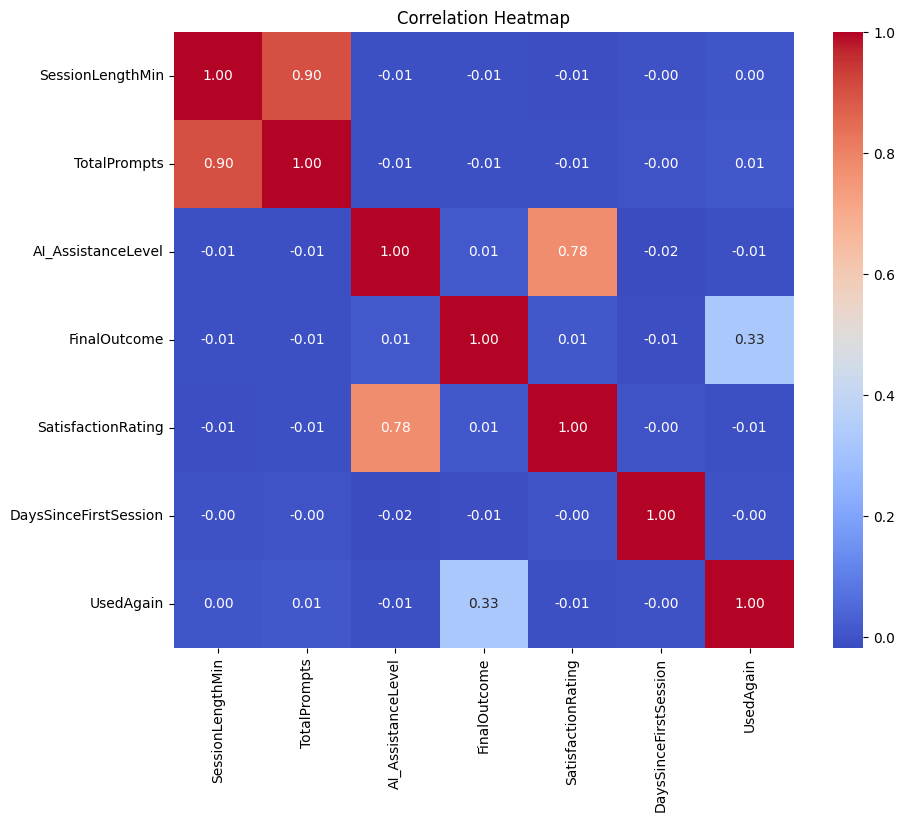

In [7]:
# Creating a correlation matrix

corr_data = X.assign(UsedAgain=y)
corr = corr_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")

Matrix confirmes my assumptions based on previous plots, that SatisfactionRating and AI_AssistanceLevel have no correlation with my label. What's worse, none of the numeric values have. It seems only FinalOutcome has any correlation with the label.

              precision    recall  f1-score   support

           0       0.56      0.36      0.44       587
           1       0.77      0.88      0.82      1413

    accuracy                           0.73      2000
   macro avg       0.67      0.62      0.63      2000
weighted avg       0.71      0.73      0.71      2000

ROC-AUC: 0.663510888790026


Text(50.722222222222214, 0.5, 'Actual')

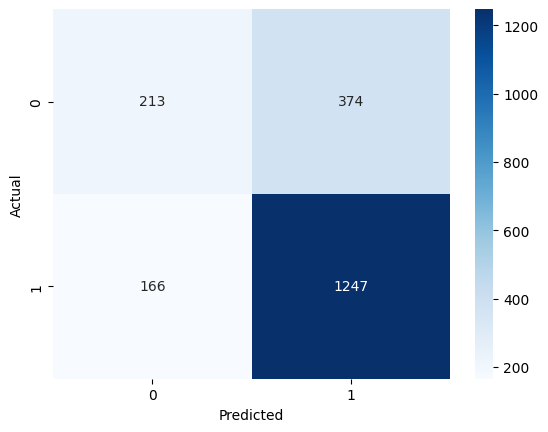

In [12]:
# Based on data analysis, I have little chance 
# to train well-working model, but I'll try anyway.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix

cut_data = data.drop(columns=["SessionID", "SessionDate", "Discipline", "TaskType", "StudentLevel"])
cut_data["days_cat"] = pd.cut(cut_data['DaysSinceFirstSession'],
                              bins=[0,50,100,150,200,250,300, np.inf])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=200, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
